In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import seaborn as sns
import plotly.graph_objects as go
from typing import Dict, Any, Optional
import plotly.express as px
import ast

_RESNET18_BENCHMARK=0.9545
_WIDE_RESNET_BENCHMARK=0.95
_IMAGENET_BENCHMARK=0.7674

plt.style.use("../plt_plot_style.mplstyle")
f_name = "../project.csv"
raw_df = pd.read_csv(f_name)
raw_df.shape


# df = pd.read_csv("../processed_results.csv", index_col="id")

(1867, 8)

In [33]:
def parse_wandb_results(project_results_csv: str) -> pd.DataFrame:
    df = pd.read_csv(project_results_csv)
    df = df.set_index("id")
    config_df = df["config"].apply(lambda x: pd.json_normalize(ast.literal_eval(x)))
    config_df = pd.concat(config_df.to_dict())
    config_df.index = df.index
    summary_df = df["summary"].apply(lambda x: pd.json_normalize(ast.literal_eval(x)))
    summary_df = pd.concat(summary_df.to_dict())
    summary_df.index = df.index
    combined_df = pd.concat([df, config_df, summary_df,], axis=1)
    sorted_cols = sorted(combined_df.columns)
    combined_df = combined_df[sorted_cols]
    combined_df.to_csv("../processed_results.csv")
    return combined_df

# df = parse_wandb_results("../project.csv")
# df = pd.read_csv("../processed_results.csv", index_col="id")

In [2]:
df = pd.read_csv("../processed_results.csv", index_col="id")
df.shape


/tmp/ipykernel_611/1930373207.py:1: DtypeWarning: Columns (14,15,16,19,20,21,22,23,27,28,29,31,33,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,2

(1867, 4241)

In [4]:
groupby_cols = [
    "model",
    "rigl.dense_allocation",
    "rigl.min_salient_weights_per_neuron",
    # "training.seed",
]


df_slice = df.loc[df["tags"].str.contains("sweep_1fik36lx")]
df_slice["model"] = df_slice["model"].fillna(df_slice["model.name"])
df_slice = df_slice.groupby(groupby_cols).count()["best_accuracy"]
df_slice.loc[df_slice == 5]


/tmp/ipykernel_611/1905320429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice["model"] = df_slice["model"].fillna(df_slice["model.name"])


model          rigl.dense_allocation  rigl.min_salient_weights_per_neuron
resnet18       0.01                   0.005                                  5
                                      0.010                                  5
                                      0.050                                  5
                                      0.100                                  5
                                      0.200                                  5
                                                                            ..
wide_resnet22  0.50                   0.100                                  5
                                      0.200                                  5
                                      0.300                                  5
                                      0.400                                  5
                                      0.500                                  5
Name: best_accuracy, Length: 112, dtype: int64

In [13]:
df_slice = df.loc[df["tags"].str.contains("sweep_1fik36lx")][["rigl.min_salient_weights_per_neuron", "best_accuracy"]]
df_slice.groupby("rigl.min_salient_weights_per_neuron").mean()['best_accuracy'].sort_values(ascending=False)

rigl.min_salient_weights_per_neuron
0.500    0.935410
0.300    0.935196
0.400    0.934690
0.100    0.934469
0.200    0.934413
0.050    0.934407
0.010    0.934330
0.005    0.934153
Name: best_accuracy, dtype: float64

In [ ]:
df.loc[df["epoch"]!=250]

In [ ]:
from itertools import product

param_sweep = {"rigl.dense_allocation": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               "rigl.min_salient_weights_per_neuron":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
               "training.seed":[8746, 6037, 7303, 2078, 42],
               "model": ["resnet18", "wide_resnet22"], 
               "sweep_id": ["1fik36lx"]
}


def get_missing_params(param_sweep, df):
    keys = param_sweep.keys()
    vals = param_sweep.values()
    missing_params = []
    for instance in product(*vals):
        missing_params.append({k: v for k,v in list(zip(keys, instance))})
    return missing_params
        

# df.loc[df["sweep_id"]=="1fik36lx"]
# vars=["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron", "training.seed", "model"]
# df_slice = df.loc[df["sweep_id"]=="1fik36lx"]
# df_slice.groupby(vars).count()["best_accuracy"]
    
missing_params = get_missing_params(param_sweep, df)
# print([df[k]==v for k,v in missing_params[0].items()])


def get_df_slice(params, df):
    missing_params = []
    for instance in params:
        df_slice = df.copy()
        for k,v in instance.items():
            df_slice = df_slice.loc[df[k]==v]
        if len(df_slice) == 0:
            # print(instance)
            missing_params.append(instance)
    return missing_params


df_slice = get_df_slice(missing_params, df)
df_slice
# for params in product(dense_alloc.values(), min_sal.values(), seed.values(), model.values()):
#     print(params)
#     print(type(params))
    
# # dense_alloc.values()
# # for params in product([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],["a", "b", "c"]):
# #     print(params)
# #     print(type(params))
    
# dense_alloc

In [59]:
df_2 = df.loc[df["sweep_id"]=="1fik36lx"]

In [62]:
import pickle
with open("missing_sweep_params.pkl", "wb") as handle:
    pickle.dump(df_slice, handle)

In [61]:
for instance in df_slice:
    df_2_slice = df_2.copy()
    for k,v in instance.items():
        df_2_slice = df_2_slice.loc[df_2_slice[k]==v]
    if len(df_2_slice) != 0:
        print(instance)
        break

In [65]:
df_slice[0]

{'rigl.dense_allocation': 0.01,
 'rigl.min_salient_weights_per_neuron': 0.5,
 'training.seed': 8746,
 'model': 'resnet18',
 'sweep_id': '1fik36lx'}

In [81]:
import os
import sys
import pathlib

up_oone = pathlib.Path.cwd()

PosixPath('/home/user/condensed-sparsity/notebooks')

In [116]:
import subprocess
import pickle

with open("missing_sweep_params.pkl", 'rb') as handle:
    missing_params = pickle.load(handle)

for instance in missing_params:
    args = [f"{k}={v}" for k,v in instance.items() if k != "sweep_id"]
    arg_string = "../slurm/manual_missing_sweeps.sh "
    config_string = (
        "rigl.delta=100 "
        "rigl.grad_accumulation_n=1 "
        "training.batch_size=128 "
        "training.max_steps=null "
        "training.weight_decay=5.0e-4 "
        "training.label_smoothing=0 "
        "training.lr=0.1 "
        "training.epochs=250 "
        "training.warm_up_steps=0 "
        "training.scheduler=step_lr "
        "training.step_size=77 "
        "training.gamma=0.2 "
        "compute.distributed=False "
        "rigl.use_sparse_initialization=True "
        "rigl.init_method_str=grad_flow_init "
    )
    for x in args:
        config_string += f"{x} "
    # command = (arg_string+config_string).strip().split(" ")
    command = (arg_string+config_string)
    subprocess.run([arg_string, config_string])
    break

FileNotFoundError: [Errno 2] No such file or directory: '../slurm/manual_missing_sweeps.sh '

In [116]:
def model_state_filter(df, epoch=250):
    return df.loc[(df["state"]=="finished") & (df["epoch"]==epoch)]

def display_group_by(df, groupby_vars, sort_by = "accuracy"):
    return df.groupby(groupby_vars).mean().sort_values(by=sort_by, ascending=False)[sort_by]

def get_model_name_filter(df, model_name):
    return df.loc[((df['model.name']==model_name) | (df['model']==model_name))] 

def get_sparse_grad_flow(df):
    return df.loc[df["rigl.init_method_str"] == "grad_flow_init"]

def get_sparse_saliency(df):
    return df[df["name"].str.contains("salients_only")]

def get_model_results(df, model_name="resnet18", expected_epochs=250):
    model_df = model_state_filter(df, expected_epochs)
    model_df = get_model_name_filter(model_df, model_name)
    model_df = get_sparse_grad_flow(model_df)
    model_df = get_sparse_saliency(model_df)
    return model_df


resnet18=get_model_results(df, "resnet18", 250)
wide_resnet22=get_model_results(df, "wide_resnet22", 250)
imagenet=get_model_results(df, "resnet50", 103)
imagenet = imagenet.loc[imagenet["sweep_id"].isin(["aw7o7hz7", "snb0sphc"])]

In [4]:
for this_df in [resnet18, wide_resnet22, imagenet]:
    print(len(this_df))

161
176
12


In [5]:
imagenet.loc[imagenet["rigl.const_fan_in"]==True][["rigl.dynamic_ablation", "rigl.dense_allocation"]]

,rigl.dynamic_ablation,rigl.dense_allocation
id,,
frwudbaa,False,0.20
ekipax62,False,0.10
u8w8bk6n,False,0.05
k49dzvg3,False,0.01
tbd2s4n5,True,0.20
pwj6hktu,True,0.10
51tgdkfn,True,0.05
oqqccm3r,True,0.01


In [117]:
display_group_by(imagenet, groupby_vars=["rigl.const_fan_in", "rigl.dense_allocation", "rigl.dynamic_ablation"])

rigl.const_fan_in  rigl.dense_allocation  rigl.dynamic_ablation
False              0.20                   True                     0.74878
True               0.20                   False                    0.74782
                                          True                     0.74720
                   0.10                   True                     0.73050
False              0.10                   True                     0.72756
True               0.10                   False                    0.72592
False              0.05                   True                     0.69662
True               0.05                   True                     0.68962
                                          False                    0.68782
False              0.01                   True                     0.51354
True               0.01                   True                     0.50540
                                          False                    0.48658
Name: accuracy, dtype: float64

In [32]:
imagenet.groupby(["rigl.const_fan_in", "rigl.dense_allocation", "rigl.dynamic_ablation"]).count().index.unique()

MultiIndex([(False, 0.01,  True),
            (False, 0.05,  True),
            (False,  0.1,  True),
            (False,  0.2,  True),
            ( True, 0.01, False),
            ( True, 0.01,  True),
            ( True, 0.05, False),
            ( True, 0.05,  True),
            ( True,  0.1, False),
            ( True,  0.1,  True),
            ( True,  0.2, False),
            ( True,  0.2,  True)],
           names=['rigl.const_fan_in', 'rigl.dense_allocation', 'rigl.dynamic_ablation'])

In [20]:
imagenet["sweep_id"]

id
4dd9ect5    aw7o7hz7
ugjdyrcn    aw7o7hz7
agisu3gp    aw7o7hz7
jfxtooy0    aw7o7hz7
tbd2s4n5    aw7o7hz7
pwj6hktu    aw7o7hz7
51tgdkfn    aw7o7hz7
oqqccm3r    aw7o7hz7
Name: sweep_id, dtype: object

In [35]:
imagenet.groupby(["rigl.const_fan_in", "rigl.dense_allocation"]).count()

ITOP Rate  Learning Rate  \
rigl.const_fan_in rigl.dense_allocation                             
False             0.01                           1              1   
                  0.05                           1              1   
                  0.10                           1              3   
                  0.20                           1              1   
True              0.01                           9              9   
                  0.05                           1              1   
                  0.10                           3              7   
                  0.20                           1              1   

                                         Training Loss  Unnamed: 0  \
rigl.const_fan_in rigl.dense_allocation                              
False             0.01                               1           1   
                  0.05                               1           1   
                  0.10                               1           3   
                  0.20                               1           1   
True              0.01                               8           9   
                  0.05                               1           1   
                  0.10                               3           7   
                  0.20                               1           1   

                                         _PRUNING_RATE  _TOTAL_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                         
False             0.01                               1                      1   
                  0.05                               1                      1   
                  0.10                               1                      1   
                  0.20                               1                      1   
True              0.01                               8                      8   
                  0.05                               1                      1   
                  0.10                               3                      3   
                  0.20                               1                      1   

                                         _TOTAL_PERCENTAGE_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                     
False             0.01                                                  1   
                  0.05                                                  1   
                  0.10                                                  1   
                  0.20                                                  1   
True              0.01                                                  8   
                  0.05                                                  1   
                  0.10                                                  3   
                  0.20                                                  1   

                                         _runtime  _step  _timestamp  ...  \
rigl.const_fan_in rigl.dense_allocation                               ...   
False             0.01                          1      1           1  ...   
                  0.05                          1      1           1  ...   
                  0.10                          3      3           3  ...   
                  0.20                          1      1           1  ...   
True              0.01                          9      9           9  ...   
                  0.05                          1      1           1  ...   
                  0.10                          7      7           7  ...   
                  0.20                          1      1           1  ...   

                                         z-module.layer4.2.conv3-Max-Grad-Per-Filter.values  \
rigl.const_fan_in rigl.dense_allocation                                                       
False             0.01                                                                   1    
           

In [7]:
get_model_name_filter(df, "resnet50").groupby(["rigl.const_fan_in", "rigl.dense_allocation"]).count()

ITOP Rate  Learning Rate  \
rigl.const_fan_in rigl.dense_allocation                             
False             0.01                           2              3   
                  0.05                           1              1   
                  0.10                           3              6   
                  0.20                           1              1   
True              0.01                          12             13   
                  0.05                           1              1   
                  0.10                           4             10   
                  0.20                           1              1   

                                         Training Loss  Unnamed: 0  \
rigl.const_fan_in rigl.dense_allocation                              
False             0.01                               1           3   
                  0.05                               1           1   
                  0.10                               1           6   
                  0.20                               1           1   
True              0.01                              10          13   
                  0.05                               1           1   
                  0.10                               3          10   
                  0.20                               1           1   

                                         _PRUNING_RATE  _TOTAL_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                         
False             0.01                               1                      1   
                  0.05                               1                      1   
                  0.10                               1                      1   
                  0.20                               1                      1   
True              0.01                              10                     10   
                  0.05                               1                      1   
                  0.10                               3                      3   
                  0.20                               1                      1   

                                         _TOTAL_PERCENTAGE_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                     
False             0.01                                                  1   
                  0.05                                                  1   
                  0.10                                                  1   
                  0.20                                                  1   
True              0.01                                                 10   
                  0.05                                                  1   
                  0.10                                                  3   
                  0.20                                                  1   

                                         _runtime  _step  _timestamp  ...  \
rigl.const_fan_in rigl.dense_allocation                               ...   
False             0.01                          3      3           3  ...   
                  0.05                          1      1           1  ...   
                  0.10                          6      6           6  ...   
                  0.20                          1      1           1  ...   
True              0.01                         13     13          13  ...   
                  0.05                          1      1           1  ...   
                  0.10                         10     10          10  ...   
                  0.20                          1      1           1  ...   

                                         z-module.layer4.2.conv3-Max-Grad-Per-Filter.values  \
rigl.const_fan_in rigl.dense_allocation                                                       
False             0.01                                                                   1    
           

In [6]:
get_model_name_filter(df, "resnet50").loc[df["epoch"]==102][['name', "accuracy"]]

,name,accuracy
id,,
3b64l2u6,resnet50_imagenet_dense_alloc=None_const_fan=T...,0.76738
xhnqnd6c,resnet50_imagenet_dense_alloc=0.01_const_fan=F...,0.51386
2d4v4ezc,resnet50_imagenet_dense_alloc=0.01_const_fan=True,0.51196
8w8lu0dy,resnet50_imagenet_0.1_True_hector-test,0.69432


In [7]:


display(display_group_by(wide_resnet22, ["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]))

rigl.dense_allocation  rigl.min_salient_weights_per_neuron
0.50                   0.005                                  0.945340
0.40                   0.005                                  0.944520
0.30                   0.005                                  0.943000
0.20                   0.005                                  0.939920
0.10                   0.100                                  0.930260
                       0.010                                  0.930200
                       0.050                                  0.929780
                       0.005                                  0.928880
                       0.001                                  0.928830
                       0.000                                  0.928420
                       1.000                                  0.928167
0.05                   0.100                                  0.915660
                       1.000                                  0.915500
                  

In [10]:
display(display_group_by(resnet18, ["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]))

rigl.dense_allocation  rigl.min_salient_weights_per_neuron
0.30                   0.0050                                 0.954600
0.50                   0.0000                                 0.954120
                       2.0000                                 0.953760
                       1.0000                                 0.953540
0.75                   1.0000                                 0.953440
0.50                   10.0000                                0.953360
0.75                   3.0000                                 0.953100
0.50                   5.0000                                 0.953100
0.75                   2.0000                                 0.952900
                       0.0000                                 0.952860
0.50                   7.0000                                 0.952740
                       3.0000                                 0.952520
0.75                   5.0000                                 0.952380
                  

In [15]:
# Based on above, use 0.005 as min-salient

In [33]:
## Resnet runs
old_run_ids = [
    "1wpb02dh",
    "mqb2j0y3",
    "2mbi1968",
    "2o7r4f32",
    "2zghy7cs",
    "24ju3o5b",
    "3bu1wts2",
    # wide resnets
    "200dfvfl",
    "z43wsdbk",
    "21ymka9z",
    "20tipo0l",
    "36u2ugju",
    "3ach3s6f",
    "36sa93oj",
    "ashld1px",
    "r59jeqa6",
    "1idniv9f",
]
old_resnet18_runs = ['1wpb02dh',
 'mqb2j0y3',
 '2mbi1968',
 '2o7r4f32',
 '2zghy7cs',
 '24ju3o5b',
 '3bu1wts2']

In [31]:
resnet18 = model_state_filter(df)
resnet18 = get_model_name_filter(resnet18, "resnet18")
sparsities = [0.20,0.30,0.40,0.50]


new_high_sparse_ids = resnet18.loc[
    (resnet18["rigl.const_fan_in"]==True) & \
    (resnet18["rigl.min_salient_weights_per_neuron"] == 0.005) & \
    (resnet18["rigl.use_sparse_const_fan_in_for_ablation"] == True) & \
    (resnet18["sweep_id"].isin(["uw4nrruy", "hgqc3joo"]))
].index.to_list()


vanilla_ids = []
for s in [0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]:
    vanilla_ids.extend(
        resnet18.loc[
            (resnet18["rigl.const_fan_in"]==False) & \
            (resnet18["rigl.dense_allocation"] == s) & \
            (resnet18["sweep_id"]=="a2uywunn")
        ].index.to_list()
    )

resnet18_no_ablation_ids=[]
for s in [0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]:
    resnet18_no_ablation_ids.extend(
        resnet18.loc[
            (resnet18["rigl.const_fan_in"]==True) & \
            (resnet18["rigl.dense_allocation"] == s) & \
            (resnet18["sweep_id"]=="4hsfzsa9")  # TODO -> Rerun with sparse init
        ].index.to_list()
    )

print(df.loc[vanilla_ids].groupby("rigl.dense_allocation").count()['accuracy'])
print(df.loc[new_high_sparse_ids].groupby("rigl.dense_allocation").count()['accuracy'])
print(df.loc[resnet18_no_ablation_ids].groupby("rigl.dense_allocation").count()['accuracy'])
# print(df.loc[other_runs].groupby("rigl.dense_allocation").count()['accuracy'])
resnet_ids = vanilla_ids + new_high_sparse_ids + resnet18_no_ablation_ids
len(resnet_ids)

rigl.dense_allocation
0.01    5
0.05    5
0.10    5
0.20    5
0.30    5
0.40    5
0.50    5
Name: accuracy, dtype: int64
rigl.dense_allocation
0.01    5
0.05    5
0.10    5
0.20    5
0.30    5
0.40    5
0.50    5
Name: accuracy, dtype: int64
rigl.dense_allocation
0.01    5
0.05    5
0.10    5
0.20    5
0.30    5
0.40    5
0.50    5
Name: accuracy, dtype: int64


105

In [84]:
df.loc[resnet_ids]["rigl.dynamic_ablation"].unique()

array([False, True, nan], dtype=object)

In [5]:
model_name="wide_resnet22"
model_df = model_state_filter(df)
model_df = get_model_name_filter(model_df, model_name)
wide_const_fan_ids = []
wide_vanilla=[]
densities = [0.2,0.3,0.4,0.5,0.1,0.05,0.01]
for d in densities:
    wide_const_fan_ids.extend(
        model_df.loc[
            (model_df["rigl.min_salient_weights_per_neuron"] == 0.005) &\
            (model_df["rigl.dense_allocation"] == d) & \
            (model_df["rigl.grad_accumulation_n"]!=8) & \
            (model_df["sweep_id"].isin(["uw4nrruy", "hgqc3joo"]))
        ].index.to_list()
    )
for d in densities:
    wide_vanilla.extend(
        model_df.loc[
            (model_df["rigl.const_fan_in"]==False) & \
            (model_df["rigl.dense_allocation"] == d) & \
            (model_df["rigl.grad_accumulation_n"]!=8) & \
            (model_df["sweep_id"] == "a2uywunn")
        ].index.to_list()
    )

wideresnet22_no_ablation_ids=[]
for s in [0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]:
    wideresnet22_no_ablation_ids.extend(
        model_df.loc[
            (model_df["rigl.const_fan_in"]==True) & \
            (model_df["rigl.dense_allocation"] == s) & \
            (model_df["sweep_id"]=="4hsfzsa9")  # TODO -> Rerun with sparse init
        ].index.to_list()
    )
    
wide_res_ids=wide_vanilla+wide_const_fan_ids+wideresnet22_no_ablation_ids
len(wide_res_ids)

105

In [52]:
df.loc[wide_res_ids].groupby(["rigl.dense_allocation", "rigl.const_fan_in"]).agg("count")["accuracy"]

rigl.dense_allocation  rigl.const_fan_in
0.01                   False                 5
                       True                 10
0.05                   False                 5
                       True                 10
0.10                   False                 5
                       True                 10
0.20                   False                 5
                       True                 10
0.30                   False                 5
                       True                 10
0.40                   False                 5
                       True                 10
0.50                   False                 5
                       True                 10
Name: accuracy, dtype: int64

In [23]:
## Imagenet runs

## PLOTTING

In [15]:
def get_confidence_bounds_df(df: pd.DataFrame, alpha=0.95, target_col:str = "accuracy", x_col="sparsity"):
    df = df.copy()
    # df = df.loc[~df[target_col].isna()]
    results = {
        x_col:[],
        "mean":[],
        "lower_bound":[],
        "upper_bound":[],
    }
    for sparsity in df[x_col].unique():
        this_df = df.loc[df[x_col] == sparsity]
        results[x_col].append(sparsity)
        results["mean"].append(this_df[target_col].mean())
        lower, upper = st.t.interval(
            alpha=alpha,
            df=len(this_df[target_col])-1,
            loc=this_df[target_col].mean(),
            scale=st.sem(this_df[target_col])
        )
        results["lower_bound"].append(lower)
        results["upper_bound"].append(upper)
    return pd.DataFrame(results)

In [54]:
## Style sheet: 
style = """
# Figure properties
figure.figsize: 10, 6 # figure size in inches

# Font properties
font.size: 16 # Size of the font
font.family: sans-serif # Type of Font
font.sans-serif : "DejaVu Sans"


# Axes properties
axes.linewidth: 2  # edge linewidth
axes.labelpad: 8   # space between label and axis
axes.prop_cycle: cycler(color=['00a5bb','f79141','499585', 'd81e52', '6cb2c5' , '6c77c5', 'c5ba6c', '56ce93', 'd88fBf', 'ffd505']) # color cycle for plot lines
axes.titlepad: 20.0    # pad between axes and title in points
axes.labelsize: 16     # Axes labels size
axes.titlesize: 20     # Plot title size
axes.labelweight: 500  # Axel Labels weight
axes.titleweight: 500  # Axel Titleweight
axes.edgecolor: 262626
axes.labelcolor: 262626
axes.titlecolor: 262626

# Tick properties
# x-axis
xtick.direction: inout # direction: in, out, or inout
xtick.major.size: 0 # major tick size in points
xtick.major.width: 0 # major tick width in points
xtick.minor.size: 0 # minor tick size in points
xtick.minor.width: 0 # minor tick width in points
xtick.major.pad : 10
xtick.minor.pad: 10
xtick.labelsize : 16

# y-axis
ytick.direction: inout # direction: in, out, or inout
ytick.major.size: 0 # major tick size in points
ytick.major.width: 0 # major tick width in points
ytick.minor.size: 0 # minor tick size in points
ytick.minor.width: 0 # minor tick width in points
ytick.major.pad : 10
ytick.minor.pad: 10
ytick.labelsize : 16

# Line properties
lines.linewidth: 3.5

# Legend properties
legend.framealpha: 0.8  # opacity of legend frame
legend.frameon: False   # whether or not to draw a frame around legend
legend.fontsize: 14     # Font size of the legend
legend.borderpad : 0
#legend.borderaxespad: 1.5

#Edge Color properties
#patch.force_edgecolor: True #Edge color for the bars
"""
with open("plt_plot_style.mplstyle", "w") as handle:
  handle.write(style)

plt.style.use("./plt_plot_style.mplstyle")

In [105]:
plot_df = df.loc[resnet_ids]
for idx, (fan_in, dynamic_ablation) in enumerate(plot_df.groupby(["rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()):
    print(idx, fan_in, dynamic_ablation)

0 False False
1 True True
2 True nan


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.92614,0.922918,0.929362
1,0.95,0.94528,0.942280,0.948280
2,0.90,0.95012,0.948687,0.951553
3,0.80,0.95094,0.949884,0.951996
4,0.70,0.95310,0.950991,0.955209
5,0.60,0.95340,0.952279,0.954521
6,0.50,0.95314,0.952567,0.953713


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.91340,0.908271,0.918529
1,0.95,0.94172,0.938016,0.945424
2,0.90,0.94742,0.946006,0.948834
3,0.80,0.95182,0.949521,0.954119
4,0.70,0.95298,0.950924,0.955036
5,0.60,0.95276,0.950768,0.954752
6,0.50,0.95336,0.951517,0.955203


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.92206,0.917942,0.926178
1,0.95,0.94632,0.944084,0.948556
2,0.90,0.94986,0.947213,0.952506
3,0.80,0.95102,0.948285,0.953755
4,0.70,0.95218,0.950417,0.953943
5,0.60,0.95302,0.951173,0.954867
6,0.50,0.95346,0.951761,0.955159


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.84770,0.843689,0.851711
1,0.95,0.91908,0.917045,0.921115
2,0.90,0.93082,0.929387,0.932253
3,0.80,0.93832,0.936277,0.940363
4,0.70,0.94284,0.941409,0.944271
5,0.60,0.94494,0.943767,0.946113
6,0.50,0.94364,0.942725,0.944555


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.81274,0.803925,0.821555
1,0.95,0.91548,0.912257,0.918703
2,0.90,0.93008,0.927392,0.932768
3,0.80,0.93804,0.934372,0.941708
4,0.70,0.94280,0.940507,0.945093
5,0.60,0.94364,0.939933,0.947347
6,0.50,0.94660,0.944851,0.948349


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.81832,0.810072,0.826568
1,0.95,0.91510,0.912073,0.918127
2,0.90,0.92888,0.927244,0.930516
3,0.80,0.93992,0.938602,0.941238
4,0.70,0.94300,0.942042,0.943958
5,0.60,0.94452,0.943133,0.945907
6,0.50,0.94534,0.943118,0.947562


/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.51354,NaN,NaN
1,0.95,0.69662,NaN,NaN
2,0.90,0.72756,NaN,NaN
3,0.80,0.74878,NaN,NaN


/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.48658,NaN,NaN
1,0.95,0.68782,NaN,NaN
2,0.90,0.72592,NaN,NaN
3,0.80,0.74782,NaN,NaN


/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.50540,NaN,NaN
1,0.95,0.68962,NaN,NaN
2,0.90,0.73050,NaN,NaN
3,0.80,0.74720,NaN,NaN


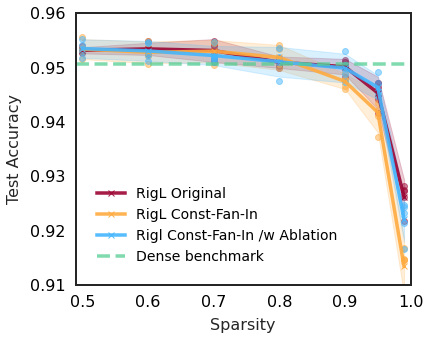

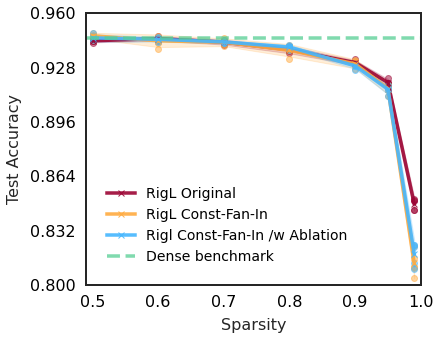

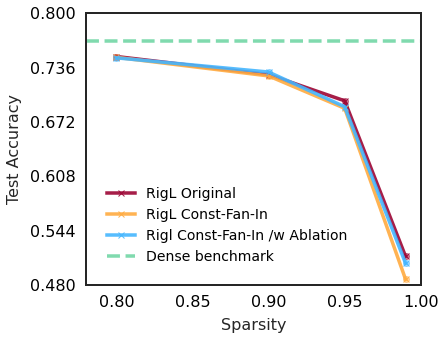

In [129]:
def get_accuracy_vs_sparsity_plot(model_name, ids, dense_benchmark_value, plot_99_sparsity=True, ylim=[0.9,1.0], xlim=[0.49,1.0]):
    _BENCHMARK_VALUE = 0.9506

    plot_df = df.loc[ids].copy().sort_values(by="rigl.dense_allocation")
    plot_df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    if not plot_99_sparsity:
      plot_df = plot_df.loc[plot_df["rigl.dense_allocation"] != 0.01]
    plot_df["sparsity"] = 1-plot_df["rigl.dense_allocation"]
    plot_dfs = []
    fig, ax = plt.subplots(figsize=(6,5))
    colors = ['#45b6fe','#ffab40','#9c0534', '#56ce93']
    # colors = ['#00a5bb','#f79141','#499585', '#d81e52', '#6cb2c5' , '#6c77c5', '#c5ba6c', '#56ce93', '#d88fBf', '#ffd505']


    for idx, (fan_in, dynamic_ablation) in enumerate(plot_df.groupby(["rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()):   
        df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == fan_in) & (plot_df["rigl.dynamic_ablation"] == dynamic_ablation)]
        if fan_in:
            if dynamic_ablation:
                name = "Rigl Const-Fan-In /w Ablation"
                color=colors[0]
            else:
                name = "RigL Const-Fan-In"
                color=colors[1]
        else:
            name = "RigL Original"
            color=colors[2]
        agg_results = get_confidence_bounds_df(df_slice)
        display(agg_results)
        ax.plot(
            agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=color, alpha=0.9
        )
        ax.fill_between(
            agg_results["sparsity"],
            agg_results["upper_bound"],
            agg_results["lower_bound"],
            color=color,
            alpha=0.20
        )
        ax.scatter(
            df_slice["sparsity"], df_slice["accuracy"], marker='o', color=color, alpha=0.5
        )

    ax.plot(xlim, [dense_benchmark_value, dense_benchmark_value], "--",  label="Dense benchmark", color=colors[3], alpha=0.75)
    model_name_dict = dict(
        resnet18="ResNet18",
        wide_resnet22="WideResNet22"
    )
    #plt.title(f"{model_name_dict[_MODEL]} CIFAR-10 Validation Set Accuracy vs. Sparsity")
    plt.xlabel('Sparsity')
    plt.ylabel('Test Accuracy')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig_name = f"{model_name}_cifar_results"
    fig.savefig(f"{model_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{model_name}.svg",format="svg", bbox_inches="tight")
    return fig

resnet18_params=dict(
    ids = resnet_ids,
    model_name ="resnet18",
    dense_benchmark_value = _RESNET18_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[0.91,0.96]
)

wide_resnet22_params=dict(
    ids = wide_res_ids,
    model_name ="wide_resnet22",
    dense_benchmark_value = _WIDE_RESNET_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[0.8,0.96]
)

imagenet_params=dict(
    ids = imagenet.index.to_list(),
    model_name ="resnet50",
    dense_benchmark_value = _IMAGENET_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[0.48,0.8],
    xlim=[0.78,1.0],
)



fig = get_accuracy_vs_sparsity_plot(**resnet18_params)
fig = get_accuracy_vs_sparsity_plot(**wide_resnet22_params)
fig = get_accuracy_vs_sparsity_plot(**imagenet_params)
fig.show()


/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sparsity,mean,lower_bound,upper_bound
0,0.99,60.874456,NaN,NaN
1,0.95,91.835994,NaN,NaN
2,0.90,97.772134,NaN,NaN
3,0.80,99.132801,NaN,NaN


/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sparsity,mean,lower_bound,upper_bound
0,0.99,58.835269,NaN,NaN
1,0.95,94.706096,NaN,NaN
2,0.90,98.642961,NaN,NaN
3,0.80,99.437591,NaN,NaN


,sparsity,mean,lower_bound,upper_bound
0,0.99,69.933472,68.116510,71.750434
1,0.95,85.484407,84.220512,86.748303
2,0.90,90.465696,89.194022,91.737371
3,0.80,95.118503,94.588399,95.648607
4,0.70,96.652807,96.225505,97.080108
5,0.60,98.216216,97.798616,98.633817
6,0.50,98.590437,98.378037,98.802836


,sparsity,mean,lower_bound,upper_bound
0,0.99,51.834719,48.652650,55.016789
1,0.95,87.900208,85.178246,90.622170
2,0.90,92.806653,90.637029,94.976276
3,0.80,98.403326,98.032643,98.774010
4,0.70,98.986486,98.250035,99.722938
5,0.60,99.671518,99.548527,99.794508
6,0.50,99.717256,99.444919,99.989593


,sparsity,mean,lower_bound,upper_bound
0,0.99,77.214555,74.436163,79.992946
1,0.95,91.982434,91.694113,92.270755
2,0.90,93.801757,93.518746,94.084767
3,0.80,94.993726,94.558622,95.428830
4,0.70,95.370138,95.230793,95.509483
5,0.60,95.006274,94.655309,95.357239
6,0.50,95.169385,95.004143,95.334628


,sparsity,mean,lower_bound,upper_bound
0,0.99,52.308657,51.696789,52.920526
1,0.95,86.976161,86.371273,87.581048
2,0.90,91.530740,91.239280,91.822201
3,0.80,94.127980,93.986475,94.269485
4,0.70,94.730238,94.307154,95.153323
5,0.60,94.629862,94.335295,94.924429
6,0.50,94.855709,94.280648,95.430770


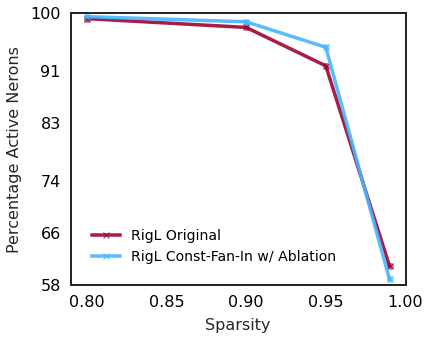

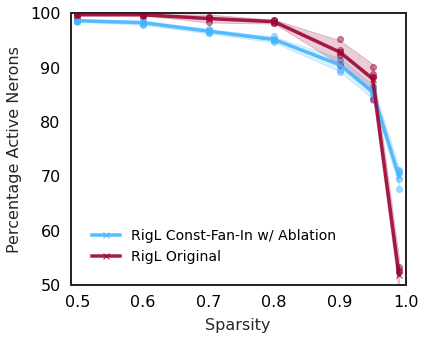

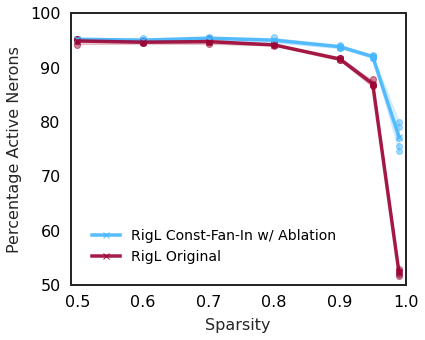

In [144]:
def plot_active_neurons_vs_sparsity(df, model_name="", ylim=[0.9,1.0], xlim=[0.49,1.0]):
    _TARGET_COL="_TOTAL_PERCENTAGE_ACTIVE_NEURONS"
    df=df.copy(deep=True)
    df = df.sort_values(by="rigl.dense_allocation")
    df["sparsity"] = 1-df["rigl.dense_allocation"]
    plot_dfs = []
    fig, ax = plt.subplots(figsize=(6,5))
    colors = ['#45b6fe','#ffab40','#9c0534'] # '#ffab40' '#ff671f'


    for idx, fan_in in enumerate(df["rigl.const_fan_in"].unique()):
        df_slice = df.loc[df["rigl.const_fan_in"] == fan_in]
        if fan_in:
            name = "RigL Const-Fan-In w/ Ablation"
            color=colors[0]
        else:
            name = "RigL Original"
            color=colors[2]
        agg_results = get_confidence_bounds_df(df_slice, target_col=_TARGET_COL)
        display(agg_results)
        ax.plot(
            agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=color, alpha=0.9
        )
        ax.fill_between(
            agg_results["sparsity"],
            agg_results["upper_bound"],
            agg_results["lower_bound"],
            color=color,
            alpha=0.20
        )
        ax.scatter(
            df_slice["sparsity"], df_slice[_TARGET_COL], marker='o', color=color, alpha=0.5
        )

    plt.xlabel('Sparsity')
    plt.ylabel('Percentage Active Nerons')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [int(min(ylim)+y_tick_eps*x) for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig.savefig(f"{model_name}_perc_active.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{model_name}_perc_active.svg",format="svg", bbox_inches="tight")
    return fig

sweep_id_ablation_exp = "a2uywunn"
df.loc[df["sweep_id"]==sweep_id_ablation_exp]["rigl.dense_allocation"].unique()

resnet18_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="resnet18")].index.to_list()
wide_resnet22_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="wide_resnet22")].index.to_list()
imagenet_ids = imagenet.loc[imagenet["rigl.dynamic_ablation"] == True].index
fig = plot_active_neurons_vs_sparsity(imagenet.loc[imagenet_ids], "imagenet", ylim=[58, 100], xlim=[0.79, 1.0])
fig = plot_active_neurons_vs_sparsity(df.loc[new_high_sparse_ids+resnet18_const_fan_false_ids], "resnet18", ylim=[50, 100])
fig = plot_active_neurons_vs_sparsity(df.loc[wide_const_fan_ids+wide_resnet22_const_fan_false_ids], "wide_resnet22", ylim=[50, 100])

# Min Salient

In [134]:

min_salient_sweep_id = "hgqc3joo"
min_sal_df = df.loc[df["sweep_id"]==min_salient_sweep_id]
# min_sal_df.groupby(["model", "rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]).count()
min_sal_df.groupby(["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]).mean()["accuracy"].sort_values(ascending=False)

rigl.dense_allocation  rigl.min_salient_weights_per_neuron
0.10                   0.100                                  0.94047
                       0.010                                  0.93973
                       0.050                                  0.93964
                       0.005                                  0.93937
                       0.001                                  0.93917
                       0.000                                  0.93838
                       1.000                                  0.93836
0.05                   0.100                                  0.93126
                       0.005                                  0.93071
                       1.000                                  0.93043
                       0.001                                  0.93029
                       0.050                                  0.93014
                       0.010                                  0.92983
                       0.000   

/tmp/ipykernel_611/691684184.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_sal_df["model"] = min_sal_df["model"].fillna(min_sal_df["model.name"])


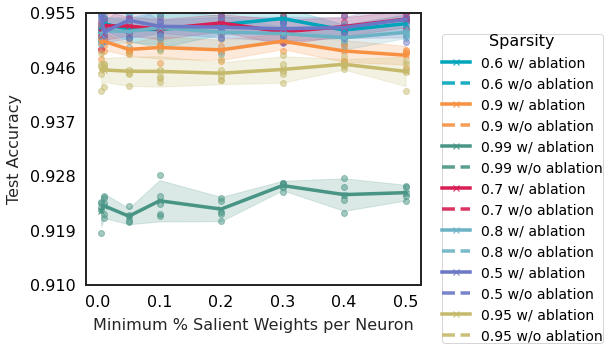

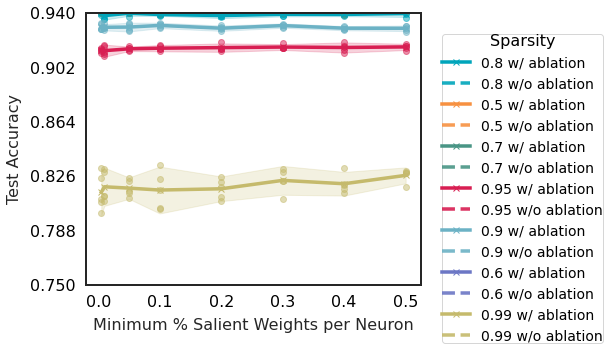

In [17]:
## Hyperparam search for min salient

def plot_min_salient_sweep(df, model_name="", ylim=[0.9,1.0], xlim=[0.49,1.0]):
    _TARGET_COL="accuracy"
    x_col = "rigl.min_salient_weights_per_neuron"
    df=df.copy(deep=True)
    df = df.sort_values(by=x_col)
    df["sparsity"] = 1-df["rigl.dense_allocation"]
    plot_dfs = []
    fig, ax = plt.subplots(figsize=(6,5))
    # colors = ['#45b6fe','#ffab40','#9c0534', '#ffab40', '#ff671f']
    colors = ['#00a5bb','#f79141','#499585', '#d81e52', '#6cb2c5' , '#6c77c5', '#c5ba6c', '#56ce93', '#d88fBf', '#ffd505']


    for idx, sparsity in enumerate(df["sparsity"].unique()):
        name=f"{sparsity} w/ ablation"
        df_slice = df.loc[df["sparsity"] == sparsity]
        agg_results = get_confidence_bounds_df(df_slice, target_col=_TARGET_COL, x_col=x_col)
        ax.plot(
            agg_results[x_col], agg_results["mean"], marker='x', label=name, color=colors[idx], alpha=1.0
        )
        ax.fill_between(
            agg_results[x_col],
            agg_results["upper_bound"],
            agg_results["lower_bound"],
            color=colors[idx],
            alpha=0.20
        )
        ax.scatter(
            df_slice[x_col], df_slice[_TARGET_COL], marker='o', color=colors[idx], alpha=0.5
        )
        benchmark_val = df_slice.loc[df_slice[x_col]==0]["accuracy"].mean()
        ax.plot(xlim, [benchmark_val, benchmark_val], "--",  label=f"{sparsity} w/o ablation", color=colors[idx], alpha=0.9)

    plt.xlabel('Minimum % Salient Weights per Neuron')
    plt.ylabel('Test Accuracy')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.legend(bbox_to_anchor=(1,1))
    ax.get_legend().set_title("Sparsity")
    ax.set_ylim(ylim)
    # ax.set_xlim(xlim)
    # ax.set_xscale("log")
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig.savefig(f"{model_name}_salient_sweep.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{model_name}_salient_sweep.svg",format="svg", bbox_inches="tight")
    return fig


# min_salient_sweep_id = "hgqc3joo"
# min_sal_df = df.loc[df["sweep_id"]==min_salient_sweep_id]
min_sal_df = df.loc[df["tags"].str.contains("sweep_1fik36lx")]
min_sal_df = df.loc[df["tags"].str.contains("sweep_1fik36lx")]
min_sal_df["model"] = min_sal_df["model"].fillna(min_sal_df["model.name"])
# min_sal_df["rigl.min_salient_weights_per_neuron"]
# for model_name in ['resnet18', 'wide_resnet22']:
fig = plot_min_salient_sweep(min_sal_df.loc[min_sal_df["model"]=="resnet18"], model_name="resnet18", ylim=[0.91,0.955], xlim=[0,1])
fig.show()
fig = plot_min_salient_sweep(min_sal_df.loc[min_sal_df["model"]=="wide_resnet22"], model_name="wide_resnet22", ylim=[0.75,0.94], xlim=[0,1])
fig.show()

In [29]:
min_sal_df = df.loc[df["tags"].str.contains("sweep_1fik36lx")]
min_sal_df["model"] = min_sal_df["model"].fillna(min_sal_df["model.name"])
# min_sal_df = min_sal_df.loc[min_sal_df["rigl.dense_allocation"]==0.05]
for model_name in ["resnet18", "wide_resnet22"]:
    display(min_sal_df.loc[min_sal_df["model"]==model_name][["rigl.min_salient_weights_per_neuron", "training.seed", "best_accuracy"]].groupby("training.seed").agg(["mean", 'std'])["best_accuracy"].sort_values(by="mean"))

/tmp/ipykernel_611/898048776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_sal_df["model"] = min_sal_df["model"].fillna(min_sal_df["model.name"])


,mean,std
training.seed,,
7303.0,0.947914,0.009410
42.0,0.948166,0.010062
2078.0,0.948202,0.009615
6037.0,0.948202,0.009620
8746.0,0.948339,0.009485


,mean,std
training.seed,,
42.0,0.920880,0.042364
6037.0,0.920995,0.042294
2078.0,0.921062,0.042162
8746.0,0.921089,0.041851
7303.0,0.921484,0.040645


In [98]:
    interested_cols=[
        "rigl.const_fan_in",
        "rigl.dynamic_ablation",
        "rigl.dense_allocation",
        "accuracy",
        "best_accuracy",
        "sparsity"
    ]
df.loc[resnet_ids].loc[~df["rigl.dynamic_ablation"].isna()][interested_cols]

,rigl.const_fan_in,rigl.dynamic_ablation,rigl.dense_allocation,accuracy,best_accuracy,sparsity
id,,,,,,
q1c5ldrm,False,False,0.01,0.9282,0.9303,0.99
gp8uog4a,False,False,0.01,0.9275,0.9298,0.99
8euvnykc,False,False,0.01,0.9217,0.9266,0.99
47keahsb,False,False,0.01,0.9261,0.9287,0.99
jn8w8nmg,False,False,0.01,0.9272,0.9288,0.99
...,...,...,...,...,...,...
cw73smba,True,True,0.01,0.9214,0.9229,0.99
723zm8do,True,True,0.01,0.9244,0.9271,0.99
ouznj6tv,True,True,0.01,0.9232,0.9255,0.99


In [100]:
df_test = df[interested_cols].groupby(["rigl.dense_allocation", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=True).agg(["mean", "std"])

In [108]:
# df_test[("sparsity", "mean")]
df_test.columns

MultiIndex([(     'accuracy', 'mean'),
            (     'accuracy',  'std'),
            ('best_accuracy', 'mean'),
            ('best_accuracy',  'std'),
            (     'sparsity', 'mean'),
            (     'sparsity',  'std')],
           )

In [150]:
def get_results_table(df, ids, benchmark_value, caption, label) -> str:
    df = get_df_for_table(df, ids)
    df=df.copy(deep=True)
    table_str=""
    table_header=(
        "\\begin{table}[h!]\n"
        "\\begin{center}\n"
        "\\begin{tabular}{ c | c | c } \n"
        "\\multirow{2}{*}{\\textbf{Sparsity (\%)}} & \\multicolumn{2}{c}{\\textbf{Test Accuracy (\%)}}\\\\ "
        "& original RigL & constant fan-in RigL \\\\"
        "\n\\hline\n"
    )
    benchmark_row= f"0  & ${benchmark_value*100:.2f}$ & -- \\\\"
    table_str+=table_header+benchmark_row
    df = df.groupby(["rigl.dense_allocation", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=True).agg(["mean", "std"])
    df = df.sort_values(by=("sparsity", "mean"), ascending=True)


    for s in df["sparsity"]["mean"].unique():
        df_slice=df.loc[df["sparsity"]['mean']==s]
        row = get_table_row(df_slice, s)
        table_str+="\n"
        table_str+=row
    
    table_footer = (
        "\\hline\n"
        "\\end{tabular}\n"
        f"\\caption{{{caption}}}\\label{{table:{label}}}\n"
        "\\end{center}\n"
        "\\end{table}\n"

    )
    table_str+=table_footer
    return table_str

def get_df_for_table(df, ids, fill_best_nan:bool=True,):
    interested_cols=[
        "rigl.const_fan_in",
        "rigl.dynamic_ablation",
        "rigl.dense_allocation",
        "accuracy",
        "best_accuracy",
        "sparsity"
    ]
    df["sparsity"] = 1-df["rigl.dense_allocation"]
    df_slice = df.loc[ids][interested_cols]
    df = df_slice.copy(deep=True)
    if fill_best_nan:
        df["best_accuracy"].loc[df["best_accuracy"].isna()] = df["accuracy"].loc[df["best_accuracy"].isna()]
        # df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    df["+/-"] = df["best_accuracy"] - df["accuracy"]
    return df
    

def get_table_row(df_slice, s):
    # Index is dense_alloc, const_fan, dynamic_ablation
    const_fan_slice = df_slice.loc[:, True, True]
    const_mean=const_fan_slice["best_accuracy"]["mean"].item()
    const_std=const_fan_slice["best_accuracy"]["std"].item()
    const_fan_text = f"{const_mean*100:.2f}"
    if not np.isnan(const_std):
        const_fan_text += f"\\pm {const_std*100:.2f}"
    else:
        const_std=0
    vanilla_slice = df_slice.loc[:, False, :]
    vanilla_mean=vanilla_slice["best_accuracy"]["mean"].item()
    vanilla_std=vanilla_slice["best_accuracy"]["std"].item()
    vanilla_text = f"{vanilla_mean*100:.2f}"
    if not np.isnan(vanilla_std):
        vanilla_text += f"\\pm {vanilla_std*100:.2f}"
    else:
        vanilla_std=0

    
    if const_mean - const_std >= vanilla_mean+vanilla_std:
        const_fan_text = f"\\mathbf{{{const_fan_text}}}"
    elif const_mean + const_std <= vanilla_mean-vanilla_std:
        vanilla_text = f"\\mathbf{{{vanilla_text}}}"
    row_text = f"{s*100:.0f} & ${vanilla_text}$ & ${const_fan_text}$ \\\\"
    return row_text

resnet18_table_args = dict(
    df=df,
    ids=resnet_ids,
    benchmark_value=_RESNET18_BENCHMARK,
    caption= "Test accuracy of ResNet-18 trained with RigL on CIFAR-10. Standard deviations are reported over five runs",
    label="resnet18_cifar10_table"
    
)

wide_resnet_table_args = dict(
    df=df,
    ids=wide_res_ids,
    benchmark_value=_WIDE_RESNET_BENCHMARK,
    caption= "Test accuracy of Wide ResNet-22 trained with RigL on CIFAR-10. Standard deviations are reported over five runs",
    label="wide_resnet22_table"
    
)

imagenet_ids = imagenet.loc[imagenet["rigl.dynamic_ablation"] == True].index
imagenet_table_args = dict(
    df=df,
    ids=imagenet_ids,
    benchmark_value=_IMAGENET_BENCHMARK,
    caption= "Test accuracy of ResNet-50 trained with RigL on ImageNet.",
    label="resnet50_imagenet_table"
    
)
for kwargs in [resnet18_table_args, wide_resnet_table_args, imagenet_table_args]:
    print(get_results_table(**kwargs))


#         50 & 95.40 $\pm 0.06$ & $95.45 \pm 0.13$ \\
#         60 & 95.45 $\pm 0.08$ & $95.39 \pm 0.10$ \\
#         70 & $95.41 \pm 0.10$ & 95.38 $\pm 0.12$ \\
#         80 & $95.20 \pm 0.08$ & 95.25 $\pm 0.17$ \\
#         90 & $95.06 \pm 0.14$ & 95.11 $\pm 0.19$ \\
#         95 & $94.62 \pm 0.20$ & 94.74 $\pm 0.15$ \\
#         99 & $\mathbf{92.88 \pm 0.14}$ & 92.43 $\pm 0.28$ \\
#          \hline
#         \end{tabular}
#     \caption{Test accuracy of ResNet-18 trained with RigL on CIFAR-10. Standard deviations are reported over five runs.}\label{table:riglexperiments}
#     \end{center}
# \end{table}

\begin{table}[h!]
\begin{center}
\begin{tabular}{ c | c | c } 
\multirow{2}{*}{\textbf{Sparsity (\%)}} & \multicolumn{2}{c}{\textbf{Test Accuracy (\%)}}\\ & original RigL & constant fan-in RigL \\
\hline
0  & $95.45$ & -- \\
50 & $95.40\pm 0.06$ & $95.45\pm 0.13$ \\
60 & $95.45\pm 0.08$ & $95.39\pm 0.10$ \\
70 & $95.41\pm 0.10$ & $95.38\pm 0.12$ \\
80 & $95.20\pm 0.08$ & $95.25\pm 0.17$ \\
90 & $95.06\pm 0.14$ & $95.11\pm 0.19$ \\
95 & $94.62\pm 0.20$ & $94.74\pm 0.15$ \\
99 & $\mathbf{92.88\pm 0.14}$ & $92.43\pm 0.28$ \\\hline
\end{tabular}
\caption{Test accuracy of ResNet-18 trained with RigL on CIFAR-10. Standard deviations are reported over five runs}\label{table:resnet18_cifar10_table}
\end{center}
\end{table}

\begin{table}[h!]
\begin{center}
\begin{tabular}{ c | c | c } 
\multirow{2}{*}{\textbf{Sparsity (\%)}} & \multicolumn{2}{c}{\textbf{Test Accuracy (\%)}}\\ & original RigL & constant fan-in RigL \\
\hline
0  & $95.00$ & -- \\
50 & $94.61\pm 0.05$ & $94.63\pm 0.13$ \\
60 & $9

/tmp/ipykernel_1415170/2589283243.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["best_accuracy"].loc[df["best_accuracy"].isna()] = df["accuracy"].loc[df["best_accuracy"].isna()]
/tmp/ipykernel_1415170/2589283243.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["best_accuracy"].loc[df["best_accuracy"].isna()] = df["accuracy"].loc[df["best_accuracy"].isna()]
/tmp/ipykernel_1415170/2589283243.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [115]:
# Tables


    
    
# updated_df = print_table(df, resnet_ids, fill_best_nan=True)
    
    